# Annotated visualisations of longevity abstracts for AIIM publication

In [1]:
import pandas as pd

df = pd.read_pickle('data/pubmed_longevity.pkl')

In [2]:
import string
import ast

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH

from textsemantics import specific_words
from utils.cluster_utils import find_cluster_words

import numpy as np
from umap import UMAP
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from IPython.display import Markdown, display

from sklearn.feature_extraction.text import TfidfVectorizer
from openTSNE import TSNE
from sklearn.mixture import GaussianMixture
from collections import Counter

/Users/primoz/PycharmProjects/text-semantics/textsemantics/specific_words.py:236: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


In [3]:
%%time
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]

        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed


abstracts = list(df['abstract'])
tokens_list = preprocess(abstracts)
texts = [' '.join(t) for t in tokens_list if len(t) > 0]
doc_embs, word_embs, _, _ = specific_words.prepare_embeddings(tokens_list, 'en')

2021-11-11 09:50:36,398 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-11 09:50:37,650 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-11 09:50:38,946 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-11 09:50:39,411 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-11 09:50:39,501 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-11 09:50:40,623 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-11-11 09:50:42,451 Warning: An empty Sentence was created! Are there empty strings in your dataset?
CPU times: user 1min 5s, sys: 6.25 s, total: 1min 11s
Wall time: 1min 40s


## t-SNE + GMM

In [4]:
%%time

tsne = TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=2,
    random_state=0,
)

embedding_ = tsne.fit(doc_embs)

CPU times: user 6min 57s, sys: 7.12 s, total: 7min 4s
Wall time: 6min 25s


In [5]:
from orangecontrib.text.stats import hypergeom_p_values
from sklearn.feature_extraction.text import CountVectorizer
from Orange.statistics.util import FDR
import matplotlib.patheffects as path_effects


CB_color_cycle = [
    '#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00'
]


def make_ellipses(gmm, ax):
    palette = sns.color_palette('colorblind', 8)
    colors = [palette[i] for i in range(gmm.n_components)]
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


def take_first_n(kws, n):
    """ 
    Take first n without duplications which are present because of normaliztion
    in YAKE    
    """
    selected = []
    for kw in kws:
        if len(selected) >= n:
            break
        if kw not in selected:
            selected.append(kw)
    assert len(selected) <= n
    return selected
    
        

def annotate_graph(points, labels, keywords, ax):
    num_kw = 20
    desc = dict()
    for i, cluster in enumerate(set(labels) - {-1}):
        cluster_idx = np.where(labels == cluster)[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
    
        clis = set(cluster_idx)
        all_kws = [
            kw for i, kws in enumerate(keywords) if i in clis 
            for kw in take_first_n(kws, num_kw)
            #for kw in kws[:num_kw]
        ]
        c = Counter(all_kws).most_common(5)

        ann = "\n".join(w for w, _ in c) + f'\n\n{i+1}'
        text = ax.text(centroid[0], centroid[1], ann, 
                fontdict={'fontweight': 'bold', 'fontsize': 'xx-large'},
                #bbox={'boxstyle': 'round','color': 'white', 'alpha': 0.3},
#                  path_effects=[path_effects.withSimplePatchShadow((2, -2))],
                va='center', ha='center')
        desc[i] = dict()
        desc[i]['idx'] = cluster_idx
        desc[i]['keywords'] = [w for w, _ in c]
    return desc


def hypergeom_clusters(points, labels, keywords, ax):
    num_kw = 20
    clusters = []
    lengths = []
    cl_labels = list(set(labels) - {-1})
    # gather keywords in list
    for i, cluster in enumerate(cl_labels):
        cluster_idx = np.where(labels == cluster)[0]
        clis = set(cluster_idx)
        all_kws = [
            take_first_n(kws, num_kw) for i, kws in enumerate(keywords) if i in clis
        ]
        lengths.append(len(all_kws))
        clusters += all_kws
    
    # count appearances
    def dummy(doc):
        return doc
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
    x = cv.fit_transform(clusters)
    features = np.array(cv.get_feature_names())
    print(x.min(), x.max())
    
    start = 0
    for i, ll in enumerate(lengths):
        # find words that should be specific for a group with hypergeom test
        selected = x[start:start+ll]
        p_values = hypergeom_p_values(x, selected)
        fdr = FDR(p_values)
        assert len(features) == len(fdr)
        bellow_threshold = set(features[np.array(fdr) < 0.05].tolist())
        
        # use counts as measure but select only words which p-vales pass the threshold
        c = Counter([k for kws in clusters[start:start+ll] for k in kws])
        selected = []
        for el, _ in c.most_common():
            if len(selected) >= 5:
                break
            if el in bellow_threshold:
                selected.append(el)     
        
        start += ll 
        # plot
        cluster_idx = np.where(labels == cl_labels[i])[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
        ann = "\n".join(selected) + f'\n\n{i+1}'
        ax.text(centroid[0], centroid[1], ann,                 
                fontdict={'fontweight': 'bold', 'fontsize': 'xx-large'},
                va='center', ha='center')

def create_plot(kw, ellipses=True, title='', label_method=annotate_graph, sublinear_tf=False):

    estimator = GaussianMixture(n_components=8,
                covariance_type='full', max_iter=20, random_state=0)

    estimator.fit(embedding_)
    _, ax = plt.subplots(figsize=(12, 12))
    plt.style.use('seaborn')

    if ellipses:
        make_ellipses(estimator, ax)

    probs = estimator.predict_proba(embedding_)
    labels = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    labels[max_probs < 0.6] = -1

    n_noise = list(labels).count(-1)
    #palette = sns.color_palette('colorblind', 8)
    palette = CB_color_cycle

    cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in labels]
    s = [36 if l > -1 else 9 for l in labels]
    plt.scatter(embedding_[:, 0], embedding_[:, 1], c=cs,
                alpha=0.3, s=s);

    desc = label_method(embedding_, labels, kw, ax)

    ax.set_xticks(())
    ax.set_yticks(())
#     ax.set_title(title + f" (Number of Gaussians: 8, n_noise: {n_noise})")
    ax.set_facecolor("white")

    return desc

In [6]:
tfidf_kw = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_kw = [[x for x, _ in wds] for wds in tfidf_kw]

/Users/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


0 1


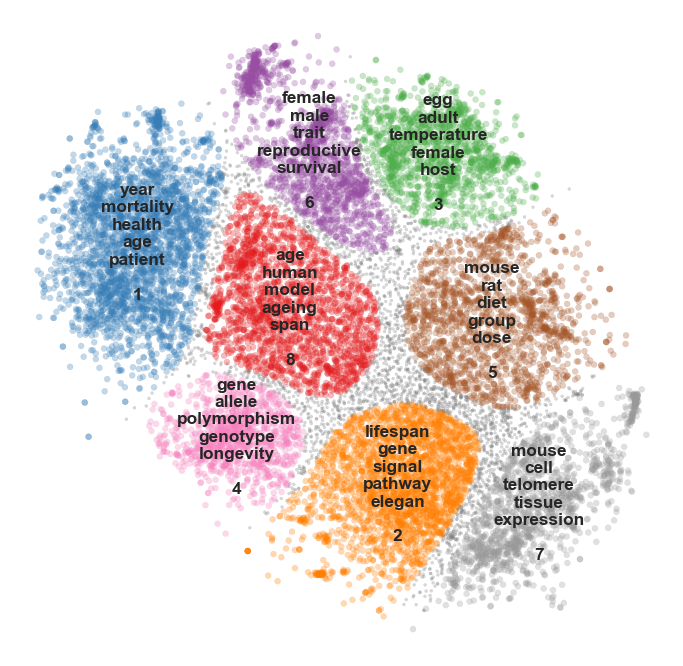

In [8]:
tfidf_desc = create_plot(tfidf_kw, ellipses=False, title='tf-idf - hyper', label_method=hypergeom_clusters)

In [9]:
%%time 
import yake

custom_kw_extractor = yake.KeywordExtractor(lan="en", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw if x not in stop_words]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 10min 35s, sys: 7.72 s, total: 10min 42s
Wall time: 11min 41s


/Users/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


0 1


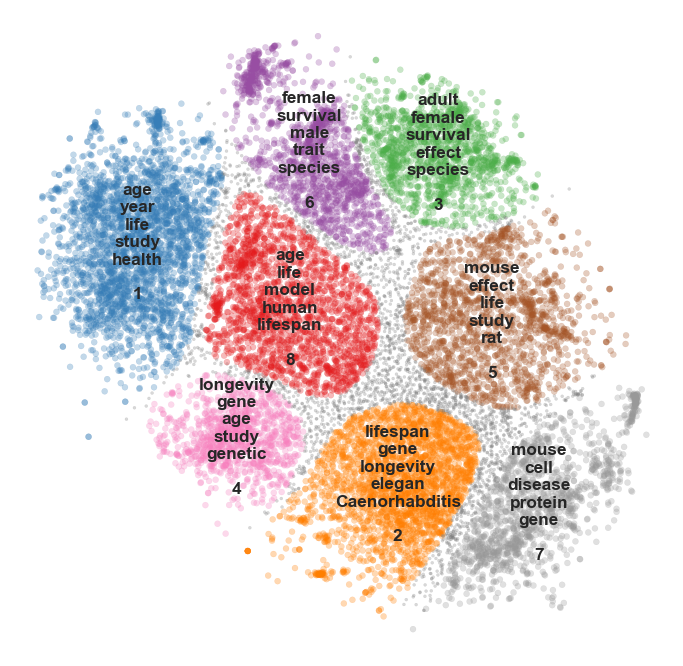

In [12]:
yake_desc = create_plot(yake_keywords, ellipses=False, title='YAKE!-hyper', label_method=hypergeom_clusters)
# plt.savefig('document-map-yake-hyper.jpg', dpi=300)

In [ ]:
def get_kws(model_path):
    extractor = TransformerKeywordExtractor(model_path)
    _bert_keywords = extractor.extract_keywords(df['abstract'])
    bert_keywords = list()
    for kws in _bert_keywords:
        current = list()
        for w, _ in kws:
            for s in w.split():
                if s not in current:
                    current.append(s)
        bert_keywords.append(list(set(current)))
    return bert_keywords
        
crosloengual_keywords = get_kws('models/crosloeng')

In [ ]:
bert_desc = create_plot(crosloengual_keywords, ellipses=False, title='BERT-hyper', label_method=hypergeom_clusters)